In [12]:
import os
import random
import json
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageColor
from utils.dataset import load_mask, load_bboxes, load_classIdxMap, load_stafflines
from utils.metropolis_hastings import metropolis_hastings, binomial_distribution, propose_state, probability_matrix

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")

OUT_PATH = os.path.join(DATASET_PATH, "unet")
OUT_TRAIN_PATH_X = os.path.join(OUT_PATH, "train", "x")
OUT_TRAIN_PATH_Y = os.path.join(OUT_PATH, "train", "y")
OUT_TEST_PATH_X = os.path.join(OUT_PATH, "test", "x")
OUT_TEST_PATH_Y = os.path.join(OUT_PATH, "test", "y")

with open(os.path.join(DATASET_PATH, "classlist.json")) as file:
    classlist = json.load(file)
    colormap = {c['color']: c['id'] for c in classlist}
    colormap_inv = {c['id']: c['color'] for c in classlist}

In [46]:
def getSystemParams(systems, idx, eps=0):
    
    sys = systems[idx]
    x0 = max(0, sys["x"] - eps)
    y0 = max(0, sys["y"] - eps)
    x1 = x0 + sys["width"] + 2 * eps
    y1 = y0 + sys["height"] + 2 * eps
    factor = 256 / (sys["height"] + 2 * eps)
    
    def map_box_coords(x, y, w, h):
        x = int((x - x0) * factor)
        y = int((y - y0) * factor)
        w = int(w * factor)
        h = int(h * factor)
        return x, y, w, h
    
    def map_img(img, interpolation=cv2.INTER_NEAREST):
        crop = img[y0:y1, x0:x1].astype(np.uint8)
        cy = (y1 + y0) // 2
        res = cv2.resize(crop, (int((x1 - x0) * factor), 256), interpolation=interpolation)
        # res = img[cy - 128: cy + 128, x0:x1]
        return res
        
    return map_box_coords, map_img

# Generate dataset from default dataset

In [47]:
out_idx = 1

# make output directories
os.makedirs(OUT_TRAIN_PATH_X, exist_ok=True)
os.makedirs(OUT_TRAIN_PATH_Y, exist_ok=True)
os.makedirs(OUT_TEST_PATH_X, exist_ok=True)
os.makedirs(OUT_TEST_PATH_Y, exist_ok=True)

for s_idx in tqdm(range(1, 26)):
    sample_idx = f"{s_idx:03d}"

    # for each sample:
    imgs = [cv2.imread(os.path.join(PNG_PATH, sample_idx, f"out-{i}.png")) for i in range(51)]
    bboxes = load_bboxes(BBOX_PATH, sample_idx, img_shape=imgs[0].shape)
    
    y_mapped = np.zeros(imgs[1].shape[:2], dtype=np.uint8)
    y_tmp = cv2.cvtColor(imgs[1], cv2.COLOR_BGR2RGB)
    for color in colormap:
        y_mapped[np.all(y_tmp == ImageColor.getcolor(color, 'RGB'), axis=2)] = colormap[color]

    systems = {bbox["id"]: bbox for bbox in bboxes if bbox["type"]=="System"}
    unique_types = list(set([bbox["type"] for bbox in bboxes if bbox["type"] != "System"]))

    for idx, type in enumerate(unique_types):
        
        # get all bboxes of current type
        tbs = [bbox for bbox in bboxes if bbox["type"] == type]
        if len(tbs)==0:
            print("no box found for:", type)
            continue
        
        # pick random bbox
        rand_idx = random.randint(0, len(tbs) - 1)
        bbox = tbs[rand_idx]
        cx = bbox["cx"]
        cy = bbox["cy"]
        w = bbox["width"]
        h = bbox["height"]
        
        # map to system coordinates
        map_box_coords, map_img = getSystemParams(systems, int(bbox["systemId"]))
        cx, cy, w, h = map_box_coords(cx, cy, w, h)
        img_x = map_img(imgs[0])
        
        # get frame centered around bbox center
        x0 = cx - 128
        x1 = cx + 128
        if x0 < 0:
            x0 = 0
            x1 = 256
        if x1 > img_x.shape[1]:
            x1 = img_x.shape[1]
            x0 = x1 - 256
            
        # split into train and test data
        if s_idx < 20:
            out_path_x = OUT_TRAIN_PATH_X
            out_path_y = OUT_TRAIN_PATH_Y
        else:
            out_path_x = OUT_TEST_PATH_X
            out_path_y = OUT_TEST_PATH_Y
        if s_idx == 20:
            out_idx = 1
        
        # crop and save x
        img_x = img_x[:, x0:x1]
        cv2.imwrite(os.path.join(out_path_x, f"{out_idx:03d}.png"), img_x)
        
        # crop and save y rgb
        img_y = map_img(imgs[1])[:, x0:x1]
        cv2.imwrite(os.path.join(out_path_y, f"{out_idx:03d}_vis.png"), img_y)
        
        # crop and save y int
        img_y_mapped = map_img(y_mapped)[:, x0:x1]
        cv2.imwrite(os.path.join(out_path_y, f"{out_idx:03d}_int.png"), img_y_mapped)
        
        img_y_multi = np.zeros((256, 256, 48), dtype=bool)
        for i in range(3, 51):
            img_y_multi[..., i-3] = np.any(map_img(imgs[i])[:, x0:x1] > 0, axis=2)
        np.save(os.path.join(out_path_y, f"{out_idx:03d}.npy"), img_y_multi)
        
        out_idx += 1

 12%|█▏        | 3/25 [01:50<13:33, 36.99s/it]


KeyboardInterrupt: 

# Generate dataset from augmented data

In [48]:
from Preprocessing.dataset import listSubFiles, groupPaths

AUG_PATH = os.path.join(DATASET_PATH, "aug")
AUG_OUT_PATH = os.path.join(DATASET_PATH, "unet_aug")
OUT_TRAIN_PATH_X = os.path.join(AUG_OUT_PATH, "train", "x")
OUT_TRAIN_PATH_Y = os.path.join(AUG_OUT_PATH, "train", "y")
OUT_TEST_PATH_X = os.path.join(AUG_OUT_PATH, "test", "x")
OUT_TEST_PATH_Y = os.path.join(AUG_OUT_PATH, "test", "y")
paths = listSubFiles(AUG_PATH, depth=3)
augmentations = groupPaths(paths, depth=2, return_group_names=True)[0]
out_idx_train = 1
out_idx_test = 1
out_idx = 1

# make output directories
os.makedirs(OUT_TRAIN_PATH_X, exist_ok=True)
os.makedirs(OUT_TRAIN_PATH_Y, exist_ok=True)
os.makedirs(OUT_TEST_PATH_X, exist_ok=True)
os.makedirs(OUT_TEST_PATH_Y, exist_ok=True)

for idx, aug in enumerate(augmentations):
    print(f"Processing augmentation ({idx}/{len(augmentations)}): {aug}, starting with index {out_idx_train}, {out_idx_test} (train, test)")
    for s_idx in tqdm(range(1, 26)):
        
        sample_idx = f"{s_idx:03d}"

        # for each sample:
        orig_img_x = cv2.imread(os.path.join(AUG_PATH, aug, "x", f"{sample_idx}.png"))
        orig_img_y = cv2.imread(os.path.join(AUG_PATH, aug, "y", f"{sample_idx}.png"))
        
        bboxes = load_bboxes(BBOX_PATH, sample_idx, img_shape=orig_img_x.shape)
        systems = {bbox["id"]: bbox for bbox in bboxes if bbox["type"]=="System"}
        unique_types = list(set([bbox["type"] for bbox in bboxes if bbox["type"] != "System"]))
        
        for idx, type in enumerate(unique_types):
            
            # get all bboxes of current type
            tbs = [bbox for bbox in bboxes if bbox["type"] == type]
            if len(tbs)==0:
                print("no box found for:", type)
                continue
            
            # pick random bbox
            rand_idx = random.randint(0, len(tbs) - 1)
            bbox = tbs[rand_idx]
            cx = bbox["cx"]
            cy = bbox["cy"]
            w = bbox["width"]
            h = bbox["height"]
            
            # map to system coordinates
            map_box_coords, map_img = getSystemParams(systems, int(bbox["systemId"]))
            cx, cy, w, h = map_box_coords(cx, cy, w, h)
            img_x = map_img(orig_img_x)
            
            # get frame centered around bbox center
            x0 = cx - 128
            x1 = cx + 128
            if x0 < 0:
                x0 = 0
                x1 = 256
            if x1 > img_x.shape[1]:
                x1 = img_x.shape[1]
                x0 = x1 - 256
                
            # split into train and test data
            if s_idx < 20:
                out_path_x = OUT_TRAIN_PATH_X
                out_path_y = OUT_TRAIN_PATH_Y
                out_idx = out_idx_train
                out_idx_train += 1
            else:
                out_path_x = OUT_TEST_PATH_X
                out_path_y = OUT_TEST_PATH_Y
                out_idx = out_idx_test
                out_idx_test += 1
            
            # crop and save x
            img_x = img_x[:, x0:x1]
            cv2.imwrite(os.path.join(out_path_x, f"{out_idx:04d}.png"), 255 - img_x)
            
            # crop and save y
            img_y = map_img(orig_img_y)[:, x0:x1]
            cv2.imwrite(os.path.join(out_path_y, f"{out_idx:04d}.png"), img_y)
            

Processing augmentation: dilation_all_k3, starting with index 1


100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


Processing augmentation: dilation_all_k5, starting with index 894


100%|██████████| 25/25 [00:17<00:00,  1.39it/s]


Processing augmentation: dilation_stafflines_k3, starting with index 1787


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Processing augmentation: dilation_stafflines_k5, starting with index 2680


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Processing augmentation: dilation_xy_lines_k3, starting with index 3573


100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Processing augmentation: dilation_xy_lines_k5, starting with index 4466


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


Processing augmentation: ideal, starting with index 5359


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Processing augmentation: staffline_interruptions, starting with index 6252


100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Processing augmentation: staffline_thickness_variation, starting with index 7145


100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


Processing augmentation: staffline_y_variation, starting with index 8038


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


# Interpolation experiments

(256, 256)

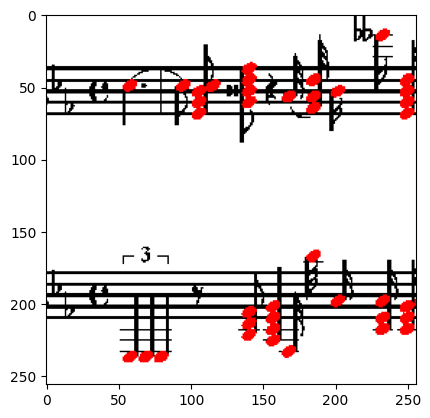

In [45]:
idx = 1
sample_idx = f"{s_idx:03d}"

# for each sample:
orig_img_x = cv2.imread(os.path.join(AUG_PATH, aug, "x", f"{sample_idx}.png"))
orig_img_y = cv2.imread(os.path.join(AUG_PATH, aug, "y", f"{sample_idx}.png"), cv2.IMREAD_GRAYSCALE)

bboxes = load_bboxes(BBOX_PATH, sample_idx, img_shape=orig_img_x.shape)
systems = {bbox["id"]: bbox for bbox in bboxes if bbox["type"]=="System"}
unique_types = list(set([bbox["type"] for bbox in bboxes if bbox["type"] != "System"]))

# get all bboxes of current type
type = unique_types[0]
tbs = [bbox for bbox in bboxes if bbox["type"] == type]

# pick random bbox
rand_idx = random.randint(0, len(tbs) - 1)
bbox = tbs[rand_idx]
cx = bbox["cx"]
cy = bbox["cy"]
w = bbox["width"]
h = bbox["height"]

# map to system coordinates
map_box_coords, map_img = getSystemParams(systems, int(bbox["systemId"]))
cx, cy, w, h = map_box_coords(cx, cy, w, h)
img_x = map_img(orig_img_x)

# get frame centered around bbox center
x0 = cx - 128
x1 = cx + 128
if x0 < 0:
    x0 = 0
    x1 = 256
if x1 > img_x.shape[1]:
    x1 = img_x.shape[1]
    x0 = x1 - 256

# crop and save y
img_y = map_img(orig_img_y, cv2.INTER_NEAREST)[:, x0:x1]
img_x = img_x[:, x0:x1]

vis = 255 - img_x
vis[img_y==8] = (255, 0, 0)
plt.imshow(vis)
# plt.imshow(img_y==8)
img_y.shape